# Matched Filter Techniques

### Jeff McMahon and Renée Hložek

We have seen how to extract an estimate for the power spectrum from a CMB map.  In this exercise we extract the point sources from our simulated maps.  We do this using the matched filter technqiue. 

## First we read in the necessary libraries.

In [1]:
import numpy as np
import matplotlib
import sys
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits


%matplotlib inline
import constants as cs # the constants module

from cmb_modules import * # the module of functions

N = cs.N
N_iterations = cs.N_iterations
c_min = cs.c_min
c_max = cs.c_max
X_width =cs.X_width
Y_width = cs.Y_width
beam_size_fwhp = cs.beam_size_fwhp

pix_size = cs.pix_size

Number_of_Sources  = cs.Number_of_Sources
Amplitude_of_Sources = cs.Amplitude_of_Sources
Number_of_Sources_EX = cs.Number_of_Sources_EX
Amplitude_of_Sources_EX = cs.Amplitude_of_Sources_EX

Number_of_SZ_Clusters  = cs.Number_of_SZ_Clusters
Mean_Amplitude_of_SZ_Clusters = cs.Mean_Amplitude_of_SZ_Clusters
SZ_beta = cs.SZ_beta
SZ_Theta_core = cs.SZ_Theta_core

white_noise_level = cs.white_noise_level
atmospheric_noise_level = 0#cs.atmospheric_noise_level
one_over_f_noise_level = 0#cs.one_over_f_noise_level

### rebuildng the simulated map from previous excercises

Number of sources required:  5000
map mean: -25.15262363457911 map rms: 101.82293917397284


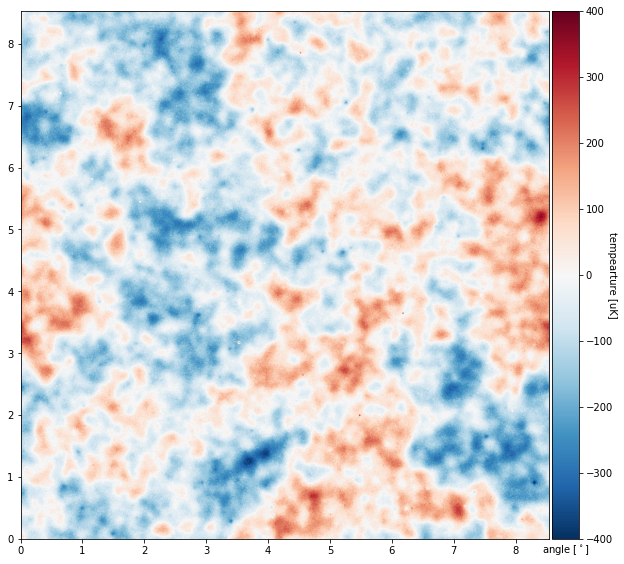

In [2]:
## Make a CMB map
ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 
CMB_T = make_CMB_T_map(N,pix_size,ell,DlTT)

N=int(N)
## make a point source map
PSMap = Poisson_source_component(N,pix_size,Number_of_Sources,Amplitude_of_Sources) 
PSMap +=  Exponential_source_component(N,pix_size,Number_of_Sources_EX,Amplitude_of_Sources_EX)

## make an SZ map
SZMap,SZCat = SZ_source_component(N,pix_size,Number_of_SZ_Clusters,Mean_Amplitude_of_SZ_Clusters,SZ_beta,SZ_Theta_core,False)

## add them all together to get the sky map at a single freuqency
total_map = CMB_T + PSMap + SZMap

## incorperate the impact of the instrument
    ## beam
CMB_T_convolved =convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,total_map)
    ## noise
Noise = make_noise_map(N,pix_size,white_noise_level,atmospheric_noise_level,one_over_f_noise_level)

total_map_plus_noise = CMB_T_convolved + Noise

total_map_plus_noise_original = total_map_plus_noise
SZCat_original = SZCat
## plot the result
p=Plot_CMB_Map(total_map_plus_noise,c_min,c_max,X_width,Y_width)

## we will need a window funciton below, so we creat that here
window = (cosine_window(N))

A few point sources and SZ sources are visible in our simulated map, however there are many that are faint and difficult to identify.  There are sophisticated techniques for isolating these sources.  We now discuss the matched filter approach.

### Constructing a matched filter

We construct a single frequency matched filter following Melin etc...  the punch line is that we build the following filter in fourier space:

$$\psi = \frac{B_\ell S_\ell }{B_\ell^2 N^2_{ap,\ell} +N^2_{ins,\ell} } $$

Both $\psi$ and all the other quantities are two dimensional in the since that they depend on $k_x$ and $k_y$.  We refer to these coordinates with a $\ell$ as shorthand.   In this equation $B_\ell$ is the Fourier transform of the beam pattern and filtering; $S_\ell$ is the Fourier transform of the signal template; $N^2_{ap,\ell}$ is the power spectrum (e.g., absolute value squared of the 2d FFT) of the astrophysical noise from sources other than what is desired to be found, and $N^2_{ins,\ell}$ is the power spectrum of the instrumental response.


In the next box we define a funciton to calculate the matched filter and a funciton to plot the resulting map.   In subsequent boxes we do the work of estimating the terms in the filter. 

In [3]:
def matched_filter(input_map,beam_and_filt,signal_profile,FT_noise_covar):
    ## input_map: the map we are processing
    ## beam_and_filt: the beam convolved with any map filtering, in real space
    ## signal_profile: the shape of the signal we are looking for, in real spcae
    ## FT_noise_covar: the B_N_{ap}^2 + N_{ins}^2 in fourier space
             ## calculating FT_npoise_covar is expensive so it is done externally
        
    FT_beam_and_filt = np.fft.fft2(np.fft.fftshift(beam_and_filt))  ## tranform beam_and_filt to fourier space
    FT_signal = np.fft.fft2(np.fft.fftshift(signal_profile))       ## tranform cluster_profile to fourier space
    
    psi = FT_beam_and_filt * FT_signal / FT_noise_covar             ## define the matchedfilter funciton
    
    filtered = psi * np.fft.fft2(np.fft.fftshift(input_map))        ## filter the map
    filtered = np.fft.fftshift(np.fft.ifft2(filtered))              ## center the filter
    filtered = np.real(filtered)                                    ## change the data type to real
    return(filtered)


def Plot_Matched_Filtered_Map(Map_to_Plot,X_width,Y_width):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    print("map mean:",np.mean(Map_to_Plot),"map rms:",np.std(Map_to_Plot))
    plt.figure(figsize=[10,10])
    im = plt.imshow(Map_to_Plot, interpolation='bilinear', origin='lower',cmap=cm.RdBu_r)
    #im.set_clim(c_min,c_max)
    ax=plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    im.set_extent([0,X_width,0,Y_width])
    plt.ylabel('angle $[^\circ]$')
    plt.xlabel('angle $[^\circ]$')
    cbar.set_label('matched_filter [S/N]', rotation=270)
    plt.show()
    return(0)
  ###############################

Following what we did above to compute the power spectrum, we will calculate the noice covariance (the denominator of in matched filter definition) using monte carlo techniques.

In [4]:
## construct the 2d noise noise covariance in fourier space
FT_noise_covar = np.zeros((N,N))  ## a 2d array to hold the result
     
N_iterations = 16

## make a series of simulated maps, find the power spectrum, and average these to esitmae the noise covariance
i = 0
while (i <N_iterations):
    ## sumilate the astrophysical map
    CMB_T = make_CMB_T_map(N,pix_size,ell,DlTT)
    PSMap = Poisson_source_component(N,pix_size,Number_of_Sources,Amplitude_of_Sources) 
    PSMap +=  Exponential_source_component(N,pix_size,Number_of_Sources_EX,Amplitude_of_Sources_EX)
    SZMap,trash = SZ_source_component(N,pix_size,Number_of_SZ_Clusters,Mean_Amplitude_of_SZ_Clusters,SZ_beta,SZ_Theta_core,False)
    CMB_T  = CMB_T + PSMap + SZMap  ## the astrophysical map
    
    ## fold in the instrument response
    CMB_T_convolved = convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,CMB_T)
    Noise = make_noise_map(N,pix_size,white_noise_level,atmospheric_noise_level,one_over_f_noise_level)
    
    ## fourier trasfomr the map
    temp =  np.fft.fft2(np.fft.fftshift(window* (CMB_T_convolved + Noise)))  ## these are the two terms in the denominator

    ## now average
    FT_noise_covar += np.real(np.conj(temp)*temp/(N_iterations*1.0))
    ## note the progress
    sys.stdout.write("\r matched filter noise realization, iterations complete: %d of %d" % ((i+1),N_iterations) )
    sys.stdout.flush()
    ## iterate
    i = i + 1

Number of sources required:  5000
 matched filter noise realization, iterations complete: 1 of 16Number of sources required:  5000
 matched filter noise realization, iterations complete: 2 of 16Number of sources required:  5000
 matched filter noise realization, iterations complete: 3 of 16Number of sources required:  5000
 matched filter noise realization, iterations complete: 4 of 16Number of sources required:  5000
 matched filter noise realization, iterations complete: 5 of 16Number of sources required:  5000
 matched filter noise realization, iterations complete: 6 of 16Number of sources required:  5000
 matched filter noise realization, iterations complete: 7 of 16Number of sources required:  5000
 matched filter noise realization, iterations complete: 8 of 16Number of sources required:  5000
 matched filter noise realization, iterations complete: 9 of 16Number of sources required:  5000
 matched filter noise realization, iterations complete: 10 of 16Number of sources required:  

Now that we have the noise covariance and a function to compute the matched filter we filter our map.   To interpret this map we will divide by the standard deviation of the filtered map to put our map in signal to noise units.   

You can play around with the number of iterations you use in the Monty Carlo of the noise term.  If it is too small you will get high frequency ringing.

map mean: -25.15262363457911 map rms: 101.82293917397284


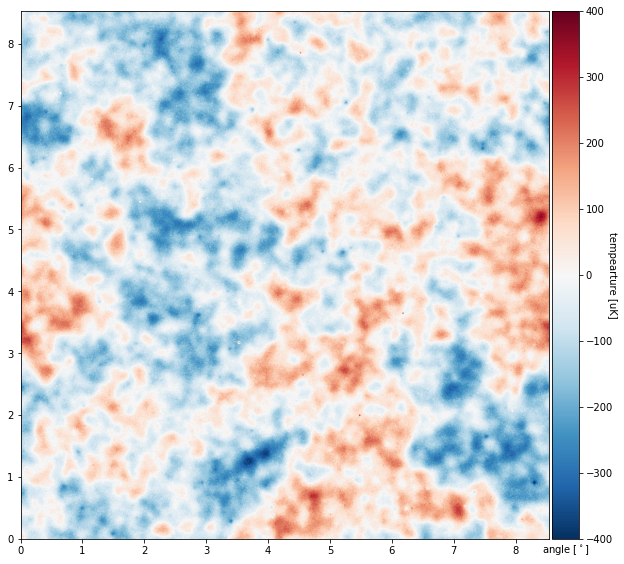

map mean: -0.0006644086842377501 map rms: 0.9999999999999999


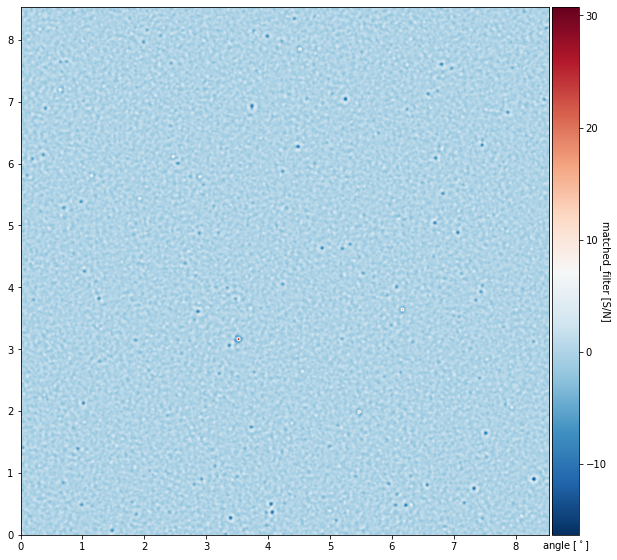

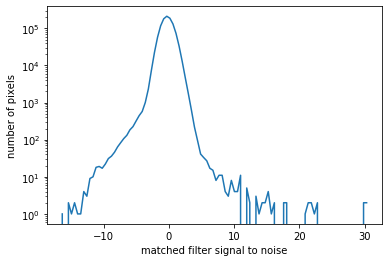

In [5]:
## construct the beam and cluster profile for the numerator of the matched filter
beam_and_filt = make_2d_gaussian_beam(N,pix_size,beam_size_fwhp)  ## this is the filtering we did on the map
cluster_profile = beta_function(N,pix_size,SZ_beta,SZ_Theta_core) ## this is the singnal we are looking for

## Apply the matched filter to our map
filtered_map = matched_filter(total_map_plus_noise_original,beam_and_filt,cluster_profile,FT_noise_covar)

## make a S/N map
SN_map = filtered_map / np.std(filtered_map)

## make a few plots
p = Plot_CMB_Map(total_map_plus_noise,c_min,c_max,X_width,Y_width)
p = Plot_Matched_Filtered_Map(SN_map,X_width,Y_width)

hist,bin_edges = np.histogram(SN_map,bins = 100,range=[SN_map.min(),SN_map.max()])
plt.semilogy(bin_edges[0:-1],hist)
plt.ylabel('number of pixels')
plt.xlabel('matched filter signal to noise')
plt.show()

Here we show three maps: (top) the raw simulated map, (middle) the matched filtered map, and (bottom) a histogram of the S/N of each pixel in the matched filter map.  You could identify SZ sources by doing a S/N cut and taking all the pixels below say -5.  To find point sources we would replace the beta function in the definition of the filter with a delta function and repeat the exercise looking for S/N greater than say 5.

NOTE: The signal to noise cut at $5 \sigma$ is not sacred.  It is chosen so that the probability of a spurious cluster (or point source) detection is controlled to be irrelevant on a ~100 degree patch with arcminute resolution.  Depending on the applicaiton this cut should be adjusted.

<font color='red'>EXCERCISE: </font>  Re-run this code with different the matched filter cluster radii on your map from part two that has multiple cluster radii and see how the S/N varries for different clusters.

In [6]:
## your code and plots go here

comment on your results here

<font color='red'>EXCERCISE: </font>  Make a matched filter for point sources.  Compar the S/N for SZ clusters and for point sources between this filtered map and the SZ filtered map.

In [7]:
## your code and plots go here

comment on your results here

<font color='red'>EXCERCISE: </font>  Extract a source list by (1) finding the highest S/N cluster detection, (2) set the pixels to zero within some radius of that cluster, and (3) iterate until you reach some S/N threshold.   Compare the source list you extract with the SZCat catalogue of true sources in the simulation.   

In [8]:
## your code and plots go here

comment on your results here

## Stacking

One often wants to understand signals at the low mass and therefore low signal to noise end of things.   If an external catalogue exists, one can co-add the signals from objects in the external catalogue to boost the signal to noise.   In this example we stack the simulated observed map and the matched filtered map at the positions of the  clusters we put into the simulation.  This highlights the opportunities that exist with stacking.  

Interpreting these results requires careful analysis.  Monte carlo simulations including selection effects and systematic effects are a particularly appealing approach.

/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


map mean: -31.052876097212806 map rms: 4.580433263869528


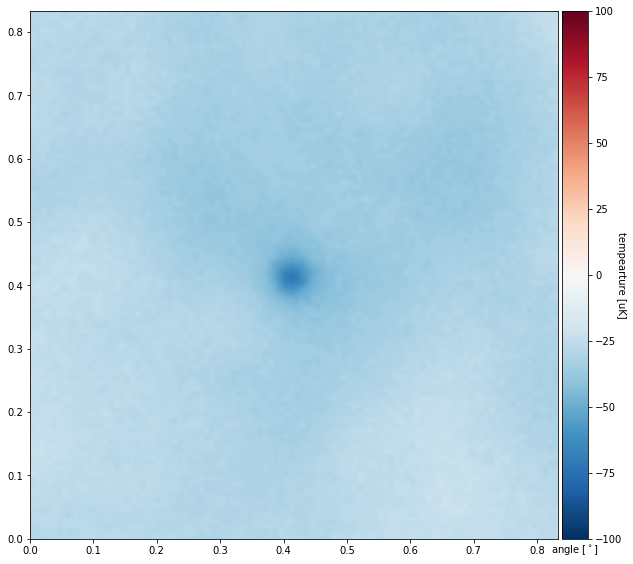

map mean: -0.001593168432985739 map rms: 0.12561900290497835


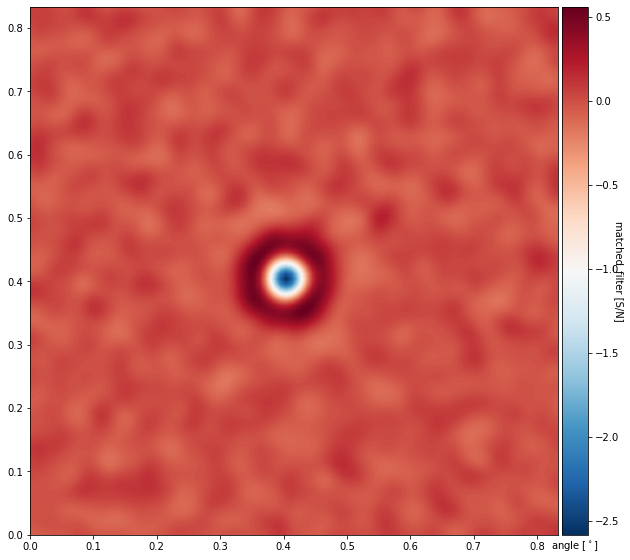

In [9]:
## take SZCat and stack total_map_plus_noise on the SZ positions, do this in a mass bin

def Stack_on_Positions(map,N,cat,N_objects,bin_min,bin_max,Radius):
    Radius = np.int(Radius)
    stack = np.zeros([Radius*2,Radius*2])
    counter = 0
    i = 0
    while (i < N_objects):
        ampl = cat[2,i]
        if ((ampl > bin_min) and (ampl <= bin_max)):
            xc = cat[0,i]
            yc = cat[1,i]
            if ((xc > Radius) and (xc < N-Radius)):
                if ((yc > Radius) and (yc < N-Radius)):
                    
                    stack += map[int(xc-Radius):int(xc+Radius),int(yc-Radius):int(yc+Radius)]
                    counter +=1
        i = i + 1
    return(stack/counter)



stack = Stack_on_Positions(total_map_plus_noise,N,SZCat,Number_of_SZ_Clusters,-100000,100000,50)
stack_SN = Stack_on_Positions(SN_map,N,SZCat,Number_of_SZ_Clusters,-100000,100000,50)

p = Plot_CMB_Map(stack,c_min/4.,c_max/4.,X_width*50*2/N,Y_width*50*2/N)
p2 = Plot_Matched_Filtered_Map(stack_SN,X_width*50*2/N,Y_width*50*2/N)

The upper plot shows the CMB temperature map stacked on the locations of SZ clusters.  The lower plot shows the same stacking exercise repeated with the matched filtered map.

<font color='red'>EXCERCISE: </font>  In this excercise you will calculate the SZ signal vs input anplitude below the S/N 5 threshold in the maps.   This is similar to calculating an SZ scaling relation from optical or x-ray selected clusters.

To do this, Divide the cluster into "SZ-amplitude" bins (the thrid column of the SZCat), calculate the peak of the stacked map (CMB and S/N) for this amplitued bin.  Find a method for estimating the nose of this stack.   Plot the recovered SZ signal vs the true amplitude.   

In [10]:
## your code and plots go here

comment on your results here

### centering errors

In this example we introduce errors in the positions of the clusters in the catalogue.  It is obvious that the cluster signal broadens and washes out. 

/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


map mean: -30.189420226120017 map rms: 4.338993781739233


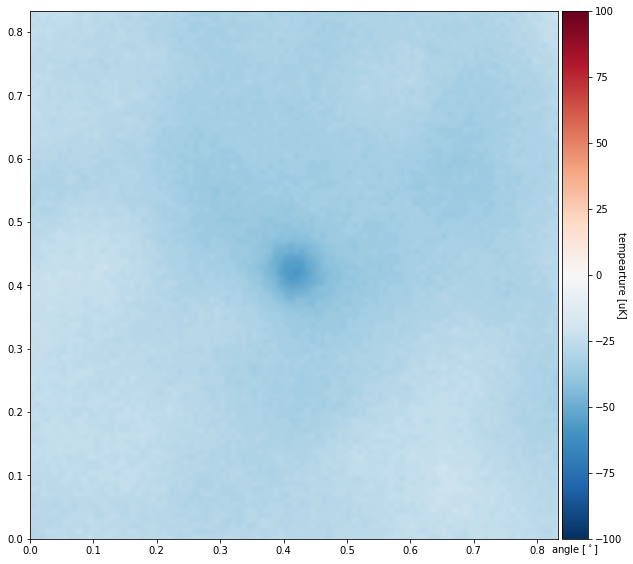

In [11]:

centering_errors_x = np.random.normal(0,2,Number_of_SZ_Clusters)
centering_errors_y = np.random.normal(0,2,Number_of_SZ_Clusters)
SZCat_centering_errs = SZCat
SZCat_centering_errs[0,:]  += centering_errors_x
SZCat_centering_errs[1,:]  += centering_errors_y

stack = Stack_on_Positions(total_map_plus_noise,N,SZCat_centering_errs,Number_of_SZ_Clusters,-100000,100000,50)
p = Plot_CMB_Map(stack,c_min/4.,c_max/4.,X_width*50*2/N,Y_width*50*2/N)





<font color='red'>EXCERCISE: </font>  Repeat excercise 18 with this centering error turned on.  Compare the results.  This is a prime example of systematics that must be accounted for in extracing SZ scaling relations through stacking.

In [12]:
## your code and plots go here

comment on your results here

## Cross-correlation of Optical and CMB Maps

An alternative to real-space stacking is Fourier-space cross-correlation.  For example one can take an optical catalogue, make a map in the same pixelization as the CMB map of the density of sources (or sum of the masses or other property), smooth that map and take the power spectrum using the techniques we used for CMB analysis.  One can furthermore take the cross-power spectrum of this map with the CMB map (or potentially a component-separated map or a lensing map, which would isolate the signal of interest for the cross-correlation).

Let's make a simple mock optical galaxy map that is correlated with the thermal SZ signal in our CMB map (which we generated in Part 02), and then measure the cross-power spectrum to detect the tSZ - galaxy number density cross-correlation.

A common way to model the distribution of galaxies in the universe is the "Halo Occupation Distribution" (HOD) formalism.  In the HOD approach, one assigns galaxies to dark matter halos as a function of the halo mass, redshift, and/or other properties.  One complexity is that there are two sub-populations of galaxies to consider: (1) central galaxies, of which there is at most one in each halo (usually located at or near the "center" of the halo), and which is typically by far the largest and brightest galaxy in that halo; (2) satellite galaxies, of which there can be many in each halo, and which are distributed in some fashion around the central galaxy within the halo.

A popular HOD model is that of Zheng et al. (2007), which models the number of central galaxies ($N_c$) and satellite galaxies ($N_s$) as follows:
$$
N_c(M) = \frac{1}{2}\left[1+\mathrm{erf}\left(\frac{\log M - \log M_\mathrm{min}}{\sqrt{2}\sigma_{\log M}}\right)\right]
$$
and
$$
N_s(M) = N_c(M) \left[ \frac{M-M_0}{M'_1} \right]^{\alpha_s}
$$
where the HOD parameters are $M_\mathrm{min}$, $\sigma_{\log M}$, $\alpha_s$, $M_0$, $M'_1$, and erf is the error function $\mathrm{erf}(x)=\frac{2}{\sqrt{\pi}} \int_{0}^{x} e^{-t^2} dt$.  Intuitively, $M_\mathrm{min}$ sets the minimum halo mass required to host a central galaxy and $\sigma_{\log M}$ sets the width of the "transition" between halos hosting zero central galaxies and those hosting one.  (Note that non-integer values of $N_c$ can be thought of as a fraction of halos of that mass hosting a central galaxy.)  Similarly, $M_0$, $M'_1$, and $\alpha_s$ determine the dependence of the number of satellite galaxies on halo mass, with larger values of $\alpha_s$ leading to a steeper increase in $N_s$ at high halo masses.

<font color='red'>EXCERCISE: </font>  Plot $N_c(M,z)$ and $N_s(M,z)$ and explore their dependence on the HOD parameters.  Note that a typical value of $M_{\rm min}$ might be $5 \times 10^{12} M_{\odot}$.  Generally these values depend on the exact galaxy sample under consideration.


In [30]:
## your code goes here

To connect this HOD model with our simple SZ simulation code from Part 02, let's rephrase the HOD in terms of the cluster SZ amplitude (this would not be done in a real data analysis, but it will make our lives easier here, and this quantity is connected to the halo mass).  We'll simply replace $M$ with the SZ cluster amplitude $A_{SZ}$ in the above equations, and make judicious choices for the HOD parameters to accommodate this, i.e.:
$$
N_c(A_{SZ}) = \frac{1}{2}\left[1+\mathrm{erf}\left(\frac{\log A_{SZ} - \log A_{SZ,\mathrm{min}}}{\sqrt{2}\sigma_{\log A_{SZ}}}\right)\right]
$$
and
$$
N_s(A_{SZ}) = N_c(A_{SZ}) \left[ \frac{A_{SZ}-A_{SZ,0}}{A_{SZ,1}'} \right]^{\alpha_s}
$$

Let's set $A_{SZ,{\rm min}} = 5$, $\sigma_{\log A_{SZ}} = 1$, $A_{SZ,0} = 0$, $A_{SZ,1}' = 5$, and $\alpha_s = 1.5$.

The last ingredient we need to complete the model is a specification of the spatial distribution of satellite galaxies in each halo.  For simplicity, let's assume the satellites follow a beta profile (like the SZ), but with a more compact profile than the SZ signal.  (A beta model is not very accurate for describing satellite distributions, but it is true that the galaxy distribution tends to be more compact than the gas.)

We'll combine this simple model with our SZ simulation code from Part 02 to generate a simulated galaxy number density map.  To make things easier, let's not worry too much about the physical meaning of fractional galaxy numbers here.

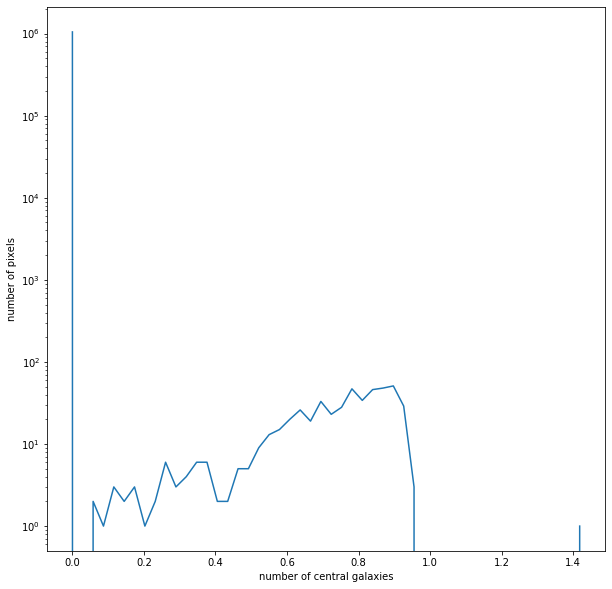

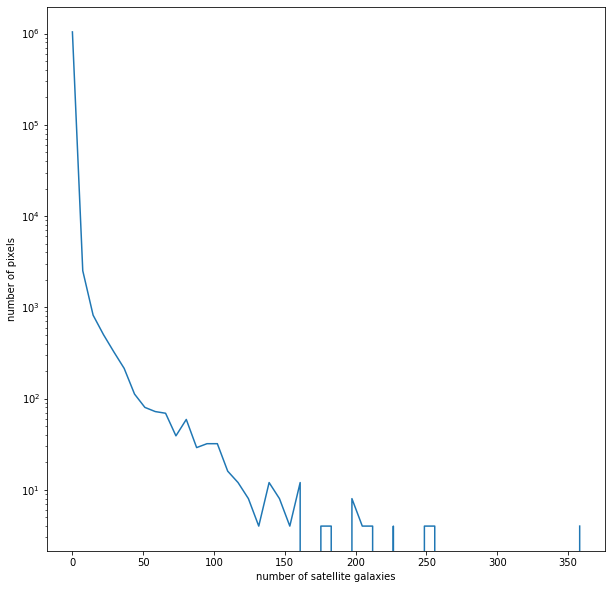

map mean: 0.0003510773505038468 map rms: 0.016594073062587877


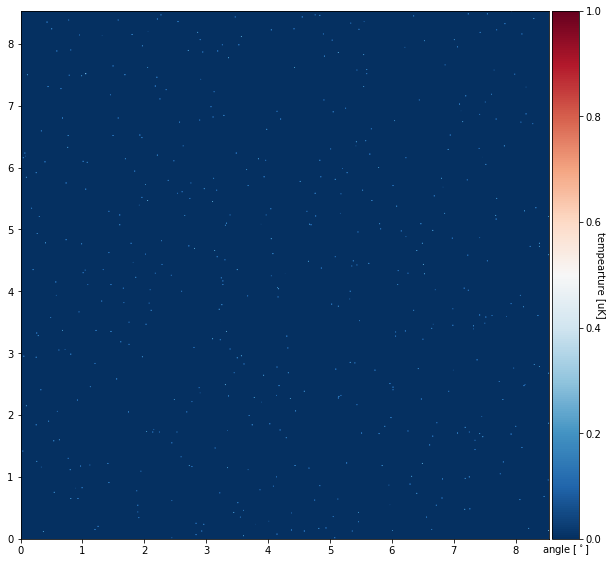

map mean: 0.2081486982776465 map rms: 2.7662924007437546


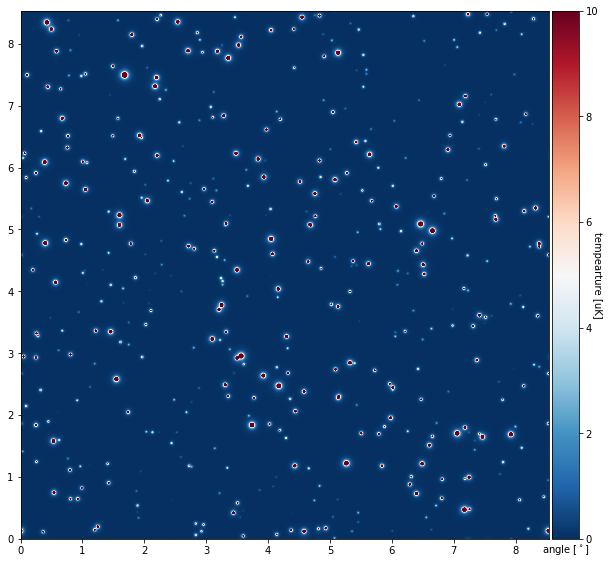

map mean: 0.2084997756281505 map rms: 2.7705083339869447


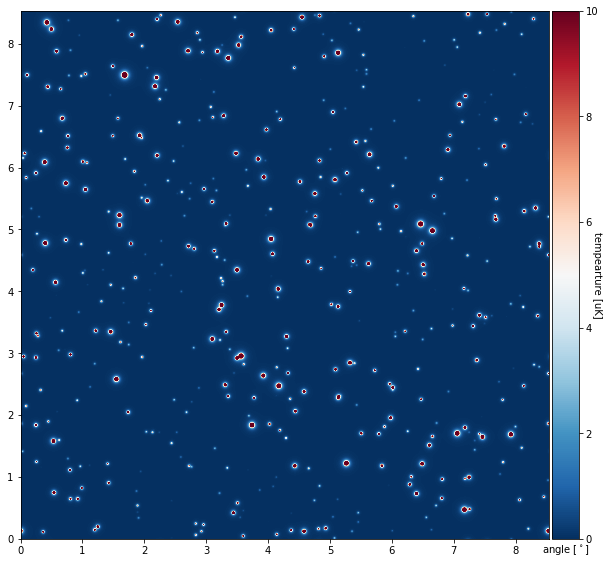

map mean: -13.596410525880016 map rms: 7.118986438828418


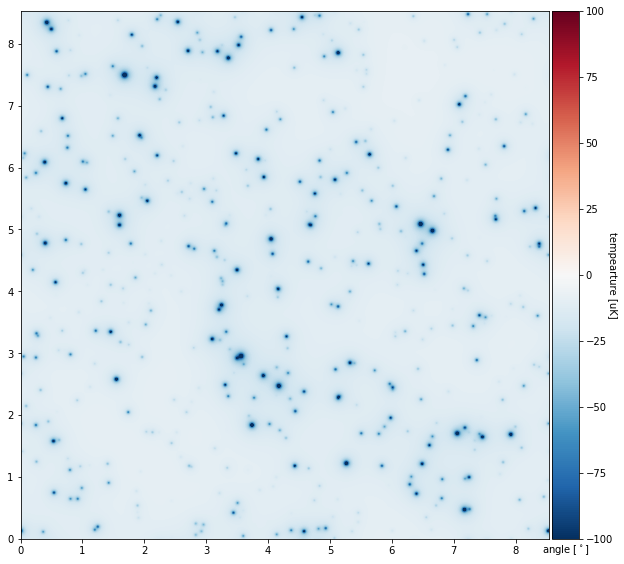

In [54]:
### parameters to set up the galaxy map
# Note: we will use SZCat from above to ensure that the cluster locations used here match those from the SZ map

satgal_beta = 1.4 #more compact (larger beta) than SZ in notebook 02
satgal_Theta_core = 0.75 #more compact (smaller theta_core) than SZ in notebook 02

from scipy.special import erf

def N_c(A_SZ, A_SZmin, sigma_logASZ):
    return 0.5*(1. + erf( (np.log10(A_SZ)-np.log10(A_SZmin))/(np.sqrt(2.)*sigma_logASZ) ))

def N_s(A_SZ, A_SZ0, Ap_SZ1, alpha_s, A_SZmin, sigma_logASZ):
    return N_c(A_SZ, A_SZmin, sigma_logASZ) * ((A_SZ-A_SZ0)/Ap_SZ1)**alpha_s

A_SZmin = 5.
sigma_logASZ = 1.
A_SZ0 = 0.
Ap_SZ1 = 5.
alpha_s = 1.5


def galaxy_component(N,pix_size,SZCat,satgal_beta,satgal_Theta_core,do_plots):
    "makes a realization of a naive galaxy number density map associated with the locations of SZ clusters"
    N=int(N)
    Number_of_SZ_Clusters = len(SZCat[0])
    CentGalMap = np.zeros([N,N]) # central galaxy map
    SatGalMap = np.zeros([N,N]) # satellite galaxy map -- need to treat separately as these have a profile
    GalMap = np.zeros([N,N]) # central+satellite galaxy map
    CentGalcat = np.zeros([3,Number_of_SZ_Clusters]) ## catalogue of SZ clusters, X, Y, amplitude
    SatGalcat = np.zeros([3,Number_of_SZ_Clusters]) ## catalogue of SZ clusters, X, Y, amplitude
    # use our existing distribution of SZ sources with varying amplitude
    i = 0
    while (i < Number_of_SZ_Clusters):
        pix_x = SZCat[0,i] #int(N*np.random.rand())
        pix_y = SZCat[1,i] #int(N*np.random.rand())
        pix_amplitude = SZCat[2,i] #np.random.exponential(Mean_Amplitude_of_SZ_Clusters)*(-1.)
        # centrals
        CentGalcat[0,i] = int(pix_x)
        CentGalcat[1,i] = int(pix_y)
        CentGalcat[2,i] = N_c(-1.*pix_amplitude, A_SZmin, sigma_logASZ)
        CentGalMap[int(pix_x),int(pix_y)] += CentGalcat[2,i]
        # satellites
        SatGalcat[0,i] = int(pix_x)
        SatGalcat[1,i] = int(pix_y)
        SatGalcat[2,i] = N_s(-1.*pix_amplitude, A_SZ0, Ap_SZ1, alpha_s, A_SZmin, sigma_logASZ)
        #print(-1.*pix_amplitude, CentGalcat[2,i], SatGalcat[2,i])
        SatGalMap[int(pix_x),int(pix_y)] += SatGalcat[2,i]
        i = i + 1
    if (do_plots):
        hist,bin_edges = np.histogram(CentGalMap,bins = 50,range=[CentGalMap.min(),CentGalMap.max()])
        plt.figure(figsize=(10,10))
        plt.semilogy(bin_edges[0:-1],hist)
        plt.xlabel('number of central galaxies')
        plt.ylabel('number of pixels')
        plt.show()      
    
    # make a beta function for the satellite galaxy distributions
    beta = beta_function(int(N),pix_size,satgal_beta,satgal_Theta_core)
    
    # convolve the beta function with the map of satellite galaxy number to get the satellite galaxy map
    # NOTE: you should go back to the Intro workshop for more practice with convolutions!
    FT_beta = np.fft.fft2(np.fft.fftshift(beta))
    FT_SatGalMap = np.fft.fft2(np.fft.fftshift(SatGalMap))
    SatGalMap = np.fft.fftshift(np.real(np.fft.ifft2(FT_beta*FT_SatGalMap)))
    
    if (do_plots):
        hist,bin_edges = np.histogram(SatGalMap,bins = 50,range=[SatGalMap.min(),SatGalMap.max()])
        plt.figure(figsize=(10,10))
        plt.semilogy(bin_edges[0:-1],hist)
        plt.xlabel('number of satellite galaxies')
        plt.ylabel('number of pixels')
        plt.show()  
    
    # return the total galaxy number map, central galaxy number map, and satellite galaxy number map
    GalMap = CentGalMap + SatGalMap
    return(GalMap,CentGalMap,SatGalMap,CentGalcat,SatGalcat)    
  ############################### 

def beta_function(N,pix_size,SZ_beta,SZ_Theta_core):
  # make a beta function

    N=int(N)
    ones = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) * pix_size
    X = np.outer(ones,inds)
    Y = np.transpose(X)
    # compute the same real-space R function as before for the PS
    R = np.sqrt(X**2. + Y**2.)
    
    beta = (1 + (R/SZ_Theta_core)**2.)**((1-3.*SZ_beta)/2.)

    # return the beta function map
    return(beta)
  ############################### 
    
## make a galaxy map
GalMap,CentGalMap,SatGalMap,CentGalcat,SatGalcat = galaxy_component(N,pix_size,SZCat,satgal_beta,satgal_Theta_core,True)

# centrals
p=Plot_CMB_Map(CentGalMap,0.,1.,X_width,Y_width)

# satellites
p=Plot_CMB_Map(SatGalMap,0.,10.,X_width,Y_width)

# total
p=Plot_CMB_Map(GalMap,0.,10.,X_width,Y_width)

p=Plot_CMB_Map(SZMap,-100.,100.,X_width,Y_width)


<font color='red'>EXCERCISE: </font>  As noted in Part 02, in reality the cluster radii vary from cluster to cluster.  Following your work in that notebook, enhance the realism of your galaxy number map by making separate maps for each of the different cluster samples that you generated in Part 02.  Combine them all into a single galaxy number map at the end.

In [ ]:
## your code here

There is one final step to take before we cross-correlate our galaxy map with our CMB map.  Conventionally, in cosmology we work with the *galaxy overdensity* field, which is the quantity most directly related to theory.  Given a map $n_g(\hat{n})$ of the number of galaxies in each direction $\hat{n}$ on the sky (i.e., in each pixel), the overdensity map is defined as
$$
\delta_g(\hat{n}) \equiv \frac{n_g(\hat{n}) - \bar{n}_g}{\bar{n}_g}
$$
where $\bar{n}_g$ is the mean number of galaxies in the original map.

Thus pixels that have no galaxies have a value of $\delta_g(\hat{n}) = -1$ in the overdensity map.

<font color='red'>EXCERCISE: </font> Convert your galaxy number map into a galaxy overdensity map.  Before we cross-correlate the galaxy overdensity map with our CMB map, compute the auto-power spectrum of your galaxy overdensity map.  Can you interpret its behavior physically, given our simple models above?

In [50]:
## your code here

Finally, we can cross-correlate our galaxy overdensity map with our CMB map.  The only component in the CMB map that correlates with the galaxy positions is the SZ component.  The other components (CMB, point sources, etc) will simply add noise to the cross-correlation.  (In fact, if we had multifrequency CMB information, we could use "component separation" techniques to extract an optimal map of the SZ component alone, which would yield a higher signal-to-noise cross-correlation.)

<font color='red'>EXCERCISE: </font> Use 'calculate_2d_spectrum' from Part 04 to compute the cross-power spectrum of your CMB map with your galaxy overdensity map.  (Conveniently, we already wrote this function such that it is easy to input two maps rather than one.)  Do you obtain a positive or negative cross-power spectrum?  Why?

In [51]:
## your code here

We would also like to have error bars on our cross-power spectrum measurement.  We can use a simple analytic formula:
$$
\sigma^2(C_\ell^{AB}) = \frac{1}{(2\ell+1)f_{\rm sky} \Delta_\ell} \left( C_\ell^{AA} C_\ell^{BB} + (C_\ell^{AB})^2 \right)
$$

Here, $A$ and $B$ are the two fields being cross-correlated, with $AB$ labeling the cross-power spectrum and $AA$ and $BB$ the auto-power spectra, and $f_{\rm sky}$ is the sky fraction used for the measurement.  We assume that the power spectra have been measured in multipole bins of width $\Delta_{\ell}$ (you can use $\Delta_\ell = 1$ here for simplicity).

<font color='red'>EXCERCISE: </font> Compute the error bars on your cross-power spectrum measurement and include them on a plot.  Estimate the S/N of your cross-power spectrum detection.  How could the S/N be improved?

In [52]:
## your code here

You are now ready to fit theoretical models to cross-correlation measurements!  In this case, we have simulated and measured the thermal SZ - galaxy number density cross-correlation.  We could also consider cross-correlations of CMB lensing maps with galaxy number density, or similar cross-correlations with galaxy weak lensing maps.  See further examples in https://github.com/ACTCollaboration/DR4_DR5_Notebooks/blob/master/Notebooks/Section_5_Lensing_maps.ipynb .

A number of theory codes exist for interpreting such measurements, including CLASS_SZ (https://github.com/borisbolliet/class_sz), hmvec (https://github.com/simonsobs/hmvec), and CCL (https://github.com/LSSTDESC/CCL).